# 加载基本库

In [1]:
import collections
import pandas as pd
import datetime
import ffmyh
import time
import math
# from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import sklearn
from sklearn.feature_extraction import DictVectorizer


# from fastFM.datasets import make_user_item_regression
# from fastFM import als
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
import numpy as np

sklearn.__version__

'0.19.1'

# 加载数据项

In [2]:
train_df_org = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
test_df_org = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')



In [3]:
train_df_org.columns

train_df = train_df_org.copy().set_index("context_id")
test_df = test_df_org.copy().set_index("context_id")

test_df["is_trade"] = -1
train_df = train_df.append(test_df)
# print len(train_df)
# print train_df[["is_trade"]]

# 预处理数据

In [4]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from datetime import datetime

def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime('%Y-%m-%d')
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

train_df['date'] = train_df['context_timestamp'].apply(lambda x: extract_date(x))
train_df['weekday'] = train_df['context_timestamp'].apply(lambda x: extract_weekday(x))
train_df['hour'] = train_df['context_timestamp'].apply(lambda x: extract_hour(x))

m = {}
for idx, date in enumerate(sorted(train_df['date'].unique())):
    m[date]=idx
print(m)

for idx, d in enumerate(sorted(train_df['date'].unique())):
    train_df["day"] = train_df['date'].map(lambda x: m[x])

{'2018-09-18': 0, '2018-09-19': 1, '2018-09-20': 2, '2018-09-21': 3, '2018-09-22': 4, '2018-09-23': 5, '2018-09-24': 6, '2018-09-25': 7}


每天的交易率趋势和交易量趋势


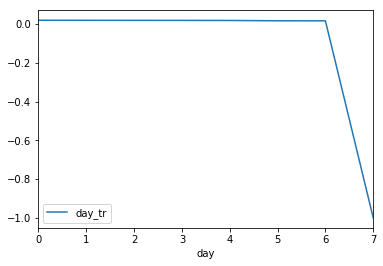

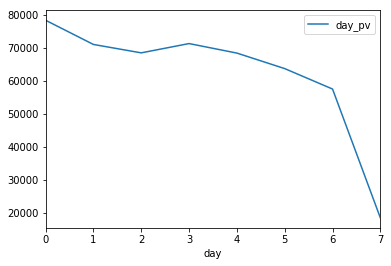

第0天的交易率趋势和交易量趋势


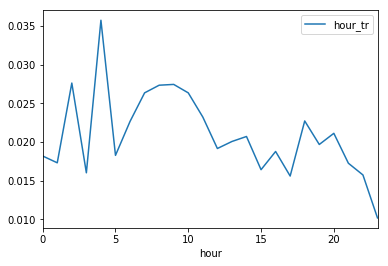

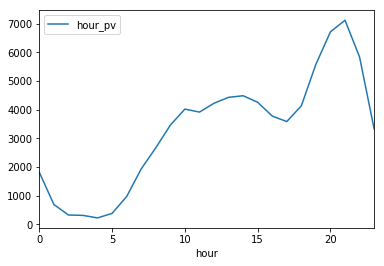

第1天的交易率趋势和交易量趋势


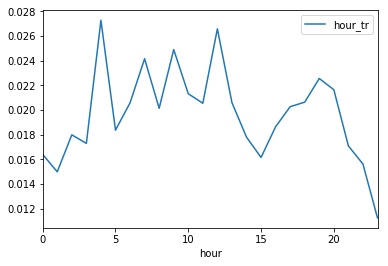

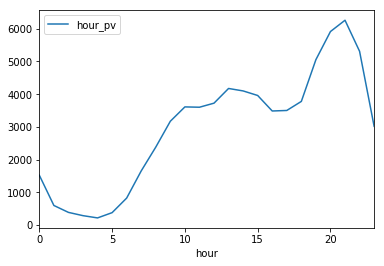

第2天的交易率趋势和交易量趋势


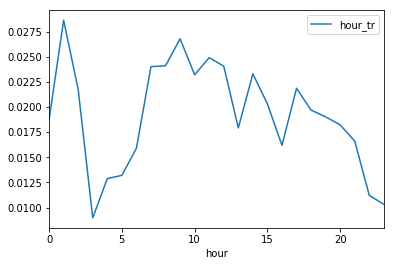

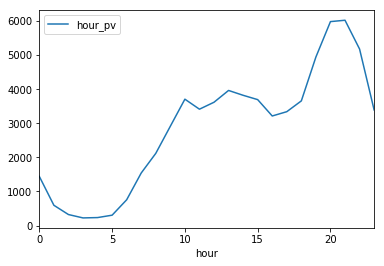

第3天的交易率趋势和交易量趋势


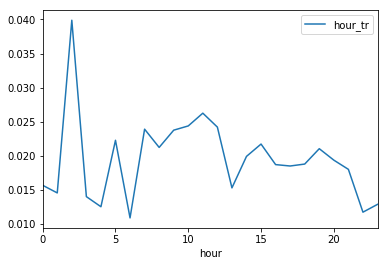

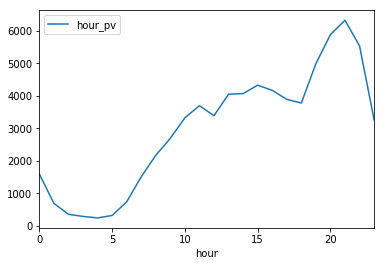

第4天的交易率趋势和交易量趋势


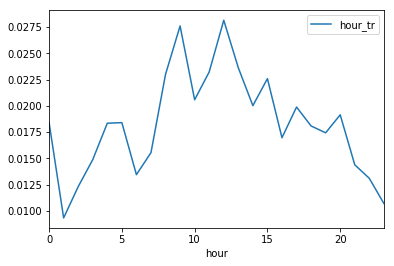

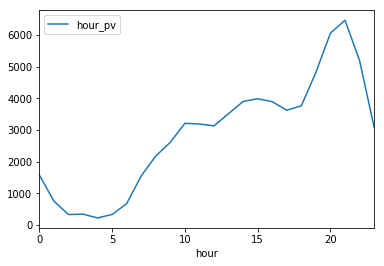

第5天的交易率趋势和交易量趋势


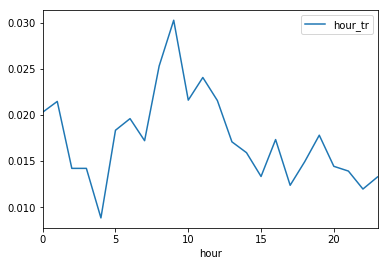

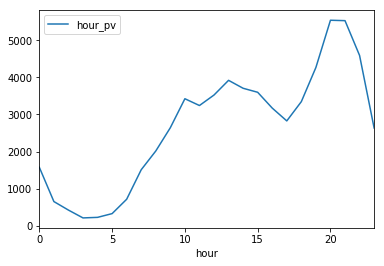

第6天的交易率趋势和交易量趋势


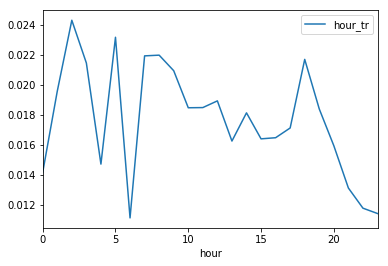

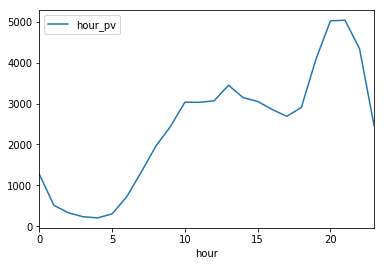

In [5]:
# import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline

def paintTradeCntAndRate(df, idCol):
    

    
    rateCol = idCol + '_tr'
    pvCol = idCol + '_pv'
    
    a = df.groupby([idCol]).agg({'is_trade':'sum'})
    b = df.groupby([idCol]).agg({'is_trade':'size'})
    c = a.join(b, lsuffix="_sum", rsuffix="_size")
    c[rateCol] = c['is_trade_sum'] / c['is_trade_size']
    c[pvCol] = c['is_trade_size']

    plt.figure()  
    c.plot(y=rateCol)
    c.plot(y=pvCol)
    plt.show()
    
print("每天的交易率趋势和交易量趋势")
paintTradeCntAndRate(train_df.copy(), "day")

for i in range(0, 7):
    print("第%s天的交易率趋势和交易量趋势" % i)
    t = train_df.copy()
    paintTradeCntAndRate(t[t["day"] == i], "hour")
# df =pd.DataFrame(np.random.randn(1000, 4), columns=list('ABCD'))   
# df = df.cumsum()  
# plt.figure(); 
# df.plot(); 
# plt.legend(loc='best')  


# 拆解复杂类型

In [6]:
#简化list等复杂类型的结构
#item_category_list全展开
#item_property_list全展开取频率>0.05的数据
#predict_category_property会计算跟item prop和cate的余弦相似度
#具体是把两个list的数据拼成cate:-1和cate:prop两种方式拼成一个字符串再跟predict_category_property的数据计算相似度
def get_icl_map(df):
    print("get_icl_map ... ")
    dfX = df.copy()
    dfX = dfX['item_category_list'].str.split(';', expand=True)

#     s = sorted(list(dfX[0].unique()) + list(dfX[1].unique()) + list(dfX[2].unique()))
    m = {}
    for i in dfX[0].unique():
        if i == None:
            continue
        m[i] = "1"
    
    for i in dfX[1].unique():
        if i == None:
            continue
        m[i] = "2"
    
    for i in dfX[2].unique():
        if i == None:
            continue
        m[i] = "3"
    return m

def get_ipl_map(df):
    print("get_ipl_map ... ")
    df1 = df.copy()
    dfX = df1.copy()['item_property_list'].str.split(';')
    dfX = pd.DataFrame(dfX)
    
    m = collections.defaultdict(float)
    idx = 0
    for _, row in dfX.iterrows():
        for i in row[0]:
            m[i] += 1
    
    ll = len(dfX)
    for k,v in m.items():
        m[k] = v / ll
    return m

def process_complex_types(dfX, icl_map, ipl_map):
    def filter_unless_cate(arr):
        ret = []
        for i in arr:
            if i in icl_map:
                ret.append(i)
        if len(ret) == 0:
            return None
        else:
            return ret
    
    def filter_unless_prop(arr):
        ret = []
        for i in arr:
            freq = ipl_map.get(i, 0.)
            if freq > 0.05:
                ret.append(i)
        if len(ret) == 0:
            return None
        else:
            return ret
    
    #{cate}:-1命中则为1分
    #{cate}:{prop}命中则为2分
    #后期优化权重
    def inner_product_recall_items(line):
        line = line.split("|")
        item_category_list = line[0].split(";")
        item_property_list = line[1].split(";")
        
        whole_combines = {}
        for cate in item_category_list:
            tmp = cate+":"+"-1"
            whole_combines[tmp] = 1
            for prop in item_property_list:
                tmp = cate+":"+prop
                whole_combines[tmp] = 2
        
        
                
        predict_category_property = line[2].split(";")
        product = 0.
        item_vec_len = math.sqrt(len(whole_combines))
        user_vec_len = math.sqrt(len(predict_category_property))
        for item in predict_category_property:
            #x1 == 1
            #y1 == 1
            #x1*y1 == 1
            #x2 == 0
            #y2 == 1
            #x2*y2 == 0
            #所以product由x决定 += 1/0
            product += whole_combines.get(item, 0)
        
        return product/(item_vec_len*user_vec_len)
            
        
            
        
        
        
    print("processing predict_category_property ...")
#     dfX['predict_category_property'] = dfX['predict_category_property'].str.split(';').map(lambda x: [i.split(":")[0] for i in x]).map(filter_unless_cate)
    
    dfX['predict_richness'] =  dfX['predict_category_property'].map(lambda x: 0 if len(x.strip()) == 0 else len(x.split(";")))
    dfX['predict_category_property'] = dfX['item_category_list']+"|"+dfX['item_property_list']+"|"+dfX['predict_category_property']
    dfX['predict_category_property'] = dfX['predict_category_property'].map(inner_product_recall_items)
    
    print("processing item_property_list ...")
    dfX['item_property_richness'] = dfX['item_property_list'].map(lambda x: 0 if len(x.strip()) == 0 else len(x.split(";")))
    dfX['item_property_list'] = dfX['item_property_list'].str.split(';').map(filter_unless_prop)
    
    print("processing item_category_list ...")
    dfX['item_category_list'] = dfX['item_category_list'].str.split(';')
    
#     print "generating item_category_list01 - item_category_list03 ..."
#     dfX['item_category_list01'] = dfX['item_category_list'].map(lambda x:x[0] if x != None and len(x) > 0 else None)
#     dfX['item_category_list02'] = dfX['item_category_list'].map(lambda x:x[1] if x != None and len(x) > 1 else None)
#     dfX['item_category_list03'] = dfX['item_category_list'].map(lambda x:x[2] if x != None and len(x) > 2 else None)
    
    return dfX



# aaa = process_complex_types(train_df.copy(), get_icl_map(train_df), get_ipl_map(train_df))

train_df = process_complex_types(train_df, get_icl_map(train_df), get_ipl_map(train_df))


get_icl_map ... 
get_ipl_map ... 
processing predict_category_property ...
processing item_property_list ...
processing item_category_list ...


# 转化属性增加trade_rate + trade_pv（按前一天）

In [7]:
# 统计信息附加

def calcTVTransform(df, key, key_y, filter_src, filter_dst, smoothing = 10, mean0=None):
    if mean0 is None:
        #计算目标的平均值做平缓用
        mean0 = df.ix[filter_src, key_y].mean()
        print("mean0:", mean0)
    
    #取出key的所有值
    df['_key1'] = df[key].astype('category').values.codes
    
    
    #取出用于计算的源（后面聚合掉就没有顺序可言了）
    df_key1_y = df.ix[filter_src, ['_key1', key_y]]
    
    #根据key的取值去聚合key_y的总数和总和，用户计算rate和count
    grp1 = df_key1_y.groupby(['_key1'])
    sum1 = grp1[key_y].aggregate(np.sum)
    cnt1 = grp1[key_y].aggregate(np.size)
    
    vn_sum = 'sum_' + key
    vn_cnt = 'cnt_' + key
    
    #取出dst（带序列）的所有key
    v_codes = df.ix[filter_dst, '_key1']
    
    #得到_sum,_cnt，按dst的序列
    _sum = sum1[v_codes].values
    _cnt = cnt1[v_codes].values
    _cnt[np.isnan(_sum)] = 0    
    _sum[np.isnan(_sum)] = 0
    
    r = {}
    r['exp'] = (_sum + smoothing * mean0)/(_cnt + smoothing)
    r['cnt'] = _cnt
    return r


In [8]:
#计算前一天的交易率set到下一天，第0天用回自己
# tmp = train_df.copy()
tmp = train_df

add_count = False
# window = 2

exp = "exp_d_"
cnt = "cnt_d_"


exp_numerical = {}
cnt_numerical = {}

#此处应该处理按天为梯度的数据
for k in ['item_price_level',
'item_sales_level',
'item_collected_level',
'item_pv_level',
'user_gender_id',
'user_age_level',
'user_occupation_id',
'user_star_level',
'context_page_id',
'shop_review_num_level',
'shop_star_level']:
    exp_k = exp+k
    cnt_k = cnt+k
    for day in range(0,8):
#         start_d = max(day - window, 0)
#         end_d = max(day - 1,0)
        cal_day = max(day - 1, 0)
        set_day = day

        print("cal %s trade_rate cnt %s set to %s" % (k,cal_day, set_day))
        
        #start_d - day(不含day)用于计算，结果赋值到day上
        days1 = (tmp.day.values == cal_day)
        days2 = (tmp.day.values == set_day)
        ret = calcTVTransform(tmp, k, 'is_trade', days1, days2)
            
        tmp.loc[tmp.day.values == day, exp_k] = ret["exp"]
        
        exp_numerical[exp_k]=1
        if add_count:
            cnt_numerical[cnt_k]=1
            tmp.loc[tmp.day.values == day, cnt_k] = ret["cnt"]


cal item_price_level trade_rate cnt 0 set to 0
mean0: 0.020020953646445547


/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


cal item_price_level trade_rate cnt 0 set to 1
mean0: 0.020020953646445547
cal item_price_level trade_rate cnt 1 set to 2
mean0: 0.019681098532376536
cal item_price_level trade_rate cnt 2 set to 3
mean0: 0.01936040475528975
cal item_price_level trade_rate cnt 3 set to 4
mean0: 0.019312068989733002
cal item_price_level trade_rate cnt 4 set to 5
mean0: 0.018867648350361546
cal item_price_level trade_rate cnt 5 set to 6
mean0: 0.017276071305058635
cal item_price_level trade_rate cnt 6 set to 7
mean0: 0.016910189651869526
cal item_sales_level trade_rate cnt 0 set to 0
mean0: 0.020020953646445547
cal item_sales_level trade_rate cnt 0 set to 1
mean0: 0.020020953646445547
cal item_sales_level trade_rate cnt 1 set to 2
mean0: 0.019681098532376536
cal item_sales_level trade_rate cnt 2 set to 3
mean0: 0.01936040475528975
cal item_sales_level trade_rate cnt 3 set to 4
mean0: 0.019312068989733002
cal item_sales_level trade_rate cnt 4 set to 5
mean0: 0.018867648350361546
cal item_sales_level trade_

# 转化属性增加trade_pv（按上一小时）

In [9]:
# tmp = train_df.copy()
# # tmp = train_df

# add_count = False

# exp = "exp_h_"
# cnt = "cnt_h_"


# #此处应该处理按天为梯度的数据
# for k in ['item_price_level',
# 'item_sales_level',
# 'item_collected_level',
# 'item_pv_level',
# 'user_gender_id',
# 'user_age_level',
# 'user_occupation_id',
# 'user_star_level',
# 'context_page_id',
# 'shop_review_num_level',
# 'shop_star_level',
# 'item_brand_id',
# 'item_city_id',
# 'item_id',
# 'shop_id'
# ]:
#     exp_k = exp+k
#     cnt_k = cnt+k
#     for day in xrange(0,7):
#         for hour in xrange(1,24):
#             cal_hour = max(hour-1,0)
#             set_hour = hour
#             print "cal %s trade_rate cnt day %s hour %s set to %s" % (k, day, cal_hour, set_hour)

#             hcal = np.logical_and(tmp.day.values == day, tmp.hour.values == cal_hour)
#             hset = np.logical_and(tmp.day.values == day, tmp.hour.values == set_hour)
#             ret = calcTVTransform(tmp, k, 'is_trade', hcal, hset)

#             tmp.loc[tmp.day.values == day, exp_k] = ret["exp"]

#             exp_numerical[exp_k]=1
#             if add_count:
#                 cnt_numerical[cnt_k]=1
#                 tmp.loc[tmp.day.values == day, cnt_k] = ret["cnt"]



In [10]:
exp_numerical = list(exp_numerical.keys())
cnt_numerical = list(cnt_numerical.keys())

print(exp_numerical)
print(cnt_numerical)

['exp_d_item_price_level', 'exp_d_item_sales_level', 'exp_d_item_collected_level', 'exp_d_item_pv_level', 'exp_d_user_gender_id', 'exp_d_user_age_level', 'exp_d_user_occupation_id', 'exp_d_user_star_level', 'exp_d_context_page_id', 'exp_d_shop_review_num_level', 'exp_d_shop_star_level']
[]


# 标记训练用的列

In [11]:
#标记训练数据

target="is_trade"
                          
                          
                        
categorical=[  
#                 'shop_id',
#                 'item_brand_id',
#                 'item_city_id',
                'item_price_level',
                'item_sales_level',
                'item_collected_level',
                'item_pv_level',
                'user_gender_id',
                'user_age_level',
                'user_occupation_id',
                'user_star_level',
                'context_page_id',
                'shop_review_num_level',
                'shop_star_level',
                "weekday",
                "hour"]

numerical=[     'shop_review_positive_rate',
                'shop_score_service',
                'shop_score_delivery',
                'shop_score_description',
                'predict_category_property',
                'predict_richness',
                'item_property_richness'
                   

#                 'item_id',
#                 'user_id'
          ]+exp_numerical
listype = [
    'item_property_list', 
    'item_category_list'
]

class filter_on_cols:
    def __init__(self, target, categorical, numerical, listype):
        self.target = target
        self.categorical = categorical
        self.numerical = numerical
        self.listype = listype
        

    
#     def get_raw_simple_cols(self):
#         return [self.target]+self.categorical+self.numerical
    def get_raw_target_col(self):
        return self.target
    def get_raw_categorical_cols(self):
        return self.categorical
    
    def get_raw_numerical_cols(self):
        return self.numerical
    def get_raw_listype_cols(self):
        return self.listype
    
    def get_onehoted_cols(self, t, df):
        if t == "listype":
            org_cols = self.listype
        
        if t == "categorical":
            org_cols = self.categorical
            
        ret = []
        for org_col in org_cols:
            for cur_col in list(df.columns):
                if cur_col.find("*ONEHOT*_") != -1 and cur_col.find(org_col) != -1:
                    ret.append(cur_col)
        
        return ret
                    
                    
            
            

filter_on_cols = filter_on_cols(target, categorical, numerical, listype)

In [12]:
train_df[filter_on_cols.get_raw_numerical_cols()].describe()

,shop_review_positive_rate,shop_score_service,shop_score_delivery,shop_score_description,predict_category_property,predict_richness,item_property_richness,exp_d_item_price_level,exp_d_item_sales_level,exp_d_item_collected_level,exp_d_item_pv_level,exp_d_user_gender_id,exp_d_user_age_level,exp_d_user_occupation_id,exp_d_user_star_level,exp_d_context_page_id,exp_d_shop_review_num_level,exp_d_shop_star_level
count,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000
mean,0.994833,0.971131,0.970495,0.974870,0.104144,4.810191,34.475055,0.019122,0.019196,0.019206,0.019185,0.019201,0.019209,0.019197,0.019192,0.019208,0.019207,0.019197
std,0.011875,0.023607,0.023567,0.024823,0.074287,1.795871,10.150529,0.008289,0.005910,0.002980,0.002614,0.001895,0.003042,0.001739,0.002805,0.002703,0.003695,0.003712
min,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,6.000000,0.001889,0.001014,0.001057,0.001393,0.010130,0.001875,0.001875,0.001875,0.004412,0.001763,0.001033
25%,0.992780,0.966360,0.965677,0.969282,0.052705,3.000000,29.000000,0.014195,0.015128,0.017904,0.017940,0.018869,0.017565,0.018679,0.018384,0.018735,0.017704,0.016709
50%,1.000000,0.972347,0.971579,0.978493,0.099015,5.000000,33.000000,0.016366,0.019286,0.019162,0.019256,0.019397,0.019105,0.019032,0.019564,0.019370,0.018838,0.018953
75%,1.000000,0.977822,0.976966,0.983626,0.148888,6.000000,39.000000,0.023361,0.022023,0.020534,0.020019,0.019800,0.020799,0.019853,0.020863,0.020518,0.021639,0.022549
max,1.000000,1.000000,1.000000,1.000000,0.632456,14.000000,100.000000,0.079541,0.037022,0.035166,0.108061,0.023103,0.027407,0.022668,0.046764,0.025987,0.066678,0.085729


# 平滑处理连续型数据最后对复杂类型做onehot编码

In [13]:
tmp = train_df.copy()

In [14]:
#数据的预处理
#double系列(例如好评率)的数据存在一个问题，没有考虑到评论量，所以乘了一个评论level，类似 好评率*评论数(分桶了) = 好评量(分桶了)
#fillempty把-1设置成-0.01，配合mov2pos使用
#mov2pos把有<0的数据都集体-min，如果一个数据是0-1，有-1出现的时候，上面设置成了-0.01，所以这列数据真实是-0.01 - 1,然后我会集体-(-0.01)
#norm用了最大值最小值norm
%run FeatureProcess.py

train_df = tmp.copy()
featProc = FeatureProcess(target=target, categorical=categorical, numerical=numerical, listype = listype)

train_df["shop_review_num_level"] = train_df["shop_review_num_level"]
train_df["shop_review_positive_rate"] = train_df["shop_review_positive_rate"]*train_df["shop_review_num_level"]
train_df["shop_score_service"] = train_df["shop_score_service"]*train_df["shop_review_num_level"]
train_df["shop_score_delivery"] = train_df["shop_score_delivery"]*train_df["shop_review_num_level"]
train_df["shop_score_description"] = train_df["shop_score_description"]*train_df["shop_review_num_level"]

train_df = featProc.fillempty(train_df, -0.01)
train_df = featProc.mov2pos(train_df)
train_df = featProc.norm(train_df)
train_df[filter_on_cols.get_raw_numerical_cols()].describe()


train_df[filter_on_cols.get_raw_numerical_cols()].describe()

,shop_review_positive_rate,shop_score_service,shop_score_delivery,shop_score_description,predict_category_property,predict_richness,item_property_richness,exp_d_item_price_level,exp_d_item_sales_level,exp_d_item_collected_level,exp_d_item_pv_level,exp_d_user_gender_id,exp_d_user_age_level,exp_d_user_occupation_id,exp_d_user_star_level,exp_d_context_page_id,exp_d_shop_review_num_level,exp_d_shop_star_level
count,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000
mean,0.639616,0.639375,0.640357,0.645605,0.164666,0.293092,0.302926,0.221927,0.504951,0.532101,0.166794,0.699227,0.678924,0.833064,0.385774,0.685787,0.268718,0.214464
std,0.115715,0.115014,0.115331,0.116668,0.117458,0.138144,0.107984,0.106746,0.164126,0.087353,0.024506,0.146113,0.119156,0.083626,0.062493,0.125287,0.056925,0.043831
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.570565,0.570033,0.570808,0.575771,0.083333,0.153846,0.244681,0.158477,0.391975,0.493923,0.155123,0.673623,0.614517,0.808148,0.367774,0.663871,0.245558,0.185082
50%,0.652074,0.647059,0.648119,0.656556,0.156556,0.307692,0.287234,0.186442,0.507428,0.530811,0.167463,0.714314,0.674863,0.825125,0.394068,0.693302,0.263026,0.211584
75%,0.692828,0.695139,0.697078,0.704375,0.235412,0.384615,0.351064,0.276522,0.583439,0.571012,0.174619,0.745377,0.741204,0.864632,0.423006,0.746495,0.306179,0.254038
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
#onehot没啥好说的，就是onehot，toOneHotList实现有点不同分开了而已
train_df = featProc.toOneHot(train_df)
train_df = featProc.toOneHotList(train_df)

# train_df = featProc.cacheRun(featProc.toOneHot, train_df)
for c in train_df.columns:
    print(c)



toOneHot ...
toOneHotList ...
instance_id
item_id
item_category_list
item_property_list
item_brand_id
item_city_id
user_id
context_timestamp
shop_id
is_trade
date
day
_key1
shop_review_positive_rate
shop_score_service
shop_score_delivery
shop_score_description
predict_category_property
predict_richness
item_property_richness
exp_d_item_price_level
exp_d_item_sales_level
exp_d_item_collected_level
exp_d_item_pv_level
exp_d_user_gender_id
exp_d_user_age_level
exp_d_user_occupation_id
exp_d_user_star_level
exp_d_context_page_id
exp_d_shop_review_num_level
exp_d_shop_star_level
*ONEHOT*_item_price_level=0
*ONEHOT*_item_price_level=1
*ONEHOT*_item_price_level=2
*ONEHOT*_item_price_level=3
*ONEHOT*_item_price_level=4
*ONEHOT*_item_price_level=5
*ONEHOT*_item_price_level=6
*ONEHOT*_item_price_level=7
*ONEHOT*_item_price_level=8
*ONEHOT*_item_price_level=9
*ONEHOT*_item_price_level=10
*ONEHOT*_item_price_level=11
*ONEHOT*_item_price_level=16
*ONEHOT*_item_price_level=17
*ONEHOT*_item_sales_lev

# 定义模型函数

In [16]:
%run ffmyh.py

    
# def train_and_test_combine(train_df, test_df, res_df):
    
#     X_train = train_df.copy()
#     del X_train['is_trade']
#     y_train = train_df['is_trade']
    
#     X_test = test_df.copy()
#     del X_test['is_trade']
#     y_test = test_df['is_trade']
    
    
    
#     model = xgboost.XGBClassifier(nthread=7,max_depth=5)
#     model.fit(X_train, y_train)
    
#     y_prev_predict_train = pd.DataFrame(model.predict_proba(X_train))
#     y_prev_predict_train["idx"] = X_train.index
#     y_prev_predict_train = y_prev_predict_train.set_index("idx")
#     X_train["y_prev_predict"] = y_prev_predict_train[1]
    
#     y_prev_predict_test = pd.DataFrame(model.predict_proba(X_test))
#     y_prev_predict_test["idx"] = X_test.index
#     y_prev_predict_test = y_prev_predict_test.set_index("idx")
#     X_test["y_prev_predict"] = y_prev_predict_test[1]
    
    
# #     X_train = X_train.fillna(0)
# #     X_test = X_test.fillna(0)
    
    
#     model = LogisticRegression(max_iter=1000)
#     model.fit(X_train, y_train)
    
    
#     train_lls = log_loss(y_train,model.predict_proba(X_train))
#     test_lls = log_loss(y_test,model.predict_proba(X_test))
#     del train_df
#     del test_df
    
#     del X_train
#     del y_train
#     del X_test
#     del y_test
    
#     return train_lls, test_lls
    

def train_and_test_xgboost(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    
#     model = xgboost.XGBClassifier(reg_lambda=1.5,learning_rate=0.1,reg_alpha=0,nthread=7,n_estimators=100,max_depth=10)
    model = xgboost.XGBClassifier(nthread=7)
    model.fit(X_train, y_train)
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("xgboost_res.csv",index=False,sep=' ')
        
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_lr(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    model = LogisticRegression(n_jobs=7,tol=1e-6, max_iter=2000)
    model.fit(X_train, y_train)


    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("lr_res.csv",index=False,sep=' ')
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_randomforest(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
#     rf = RandomForestClassifier(n_estimators=32, max_depth=40, min_samples_split=100, min_samples_leaf=10,  criterion='entropy',
#                         max_features=8, verbose = 1,  bootstrap=False, n_jobs=10)
#     RandomForestClassifier(criterion='entropy',n_estimators=100,n_jobs=15)

    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=100, min_samples_leaf=10,  criterion='entropy', max_features=8, verbose = 1,  bootstrap=False)
    model.fit(X_train, y_train)
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("randomforest_res.csv",index=False,sep=' ')
        
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_gbdt(train_df, test_df, res_df):
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    model = GradientBoostingClassifier(n_estimators=100, max_depth=10, min_samples_split=100, min_samples_leaf=10, max_features=4)
    model.fit(X_train, y_train)
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("gbdt_res.csv",index=False,sep=' ')
        
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

# def train_and_test_FM(train_df, test_df, valid_):
    
#     f = [  
#                                             'shop_id',
#                                             'item_brand_id',
#                                             'item_city_id',
#                                             'item_price_level',
#                                             'item_sales_level',
#                                             'item_collected_level',
#                                             'item_pv_level',
#                                             'user_gender_id',
#                                             'user_age_level',
#                                             'user_occupation_id',
#                                             'user_star_level',
#                                             'context_page_id',
#                                             'shop_review_num_level',
#                                             'shop_star_level']
    
# #     train_df = train_df.fillna(0)
# #     test_df = test_df.fillna(0)
#     X_train = train_df[f]
#     y_train = train_df["is_trade"]
    
#     X_test = test_df[f]
#     y_test = test_df["is_trade"]
    
#     X_train_dicts = X_train.to_dict('records')
#     X_test_dicts = X_test.to_dict('records')
    
    
#     vec = DictVectorizer()
#     vectorizer = vec.fit_transform(X_train_dicts)
#     fm_X_train = sp.csc_matrix(vectorizer)
    
#     vec = DictVectorizer()
#     vectorizer = vec.fit_transform(X_test_dicts)
#     fm_X_test = sp.csc_matrix(vectorizer)

#     model = als.FMRegression(n_iter=10000, init_stdev=0.1, l2_reg_w=0, l2_reg_V=0, rank=5)
#     model.fit(fm_X_train, y_train)
    
    
    
    
#     train_lls = log_loss(y_train,model.predict(fm_X_train))
#     test_lls = log_loss(y_test,model.predict(fm_X_test))
#     del train_df
#     del test_df
    
#     del X_train
#     del y_train
#     del X_test
#     del y_test
    
#     return train_lls, test_lls

def train_and_test_FFM(train_df, test_df, res_df):
    global filter_on_cols
    
    model = FFM(target=filter_on_cols.target, categorical=filter_on_cols.categorical, numerical=filter_on_cols.numerical, listype=filter_on_cols.listype,
                                        reg_param = 0.0004,
                                        k = 4,
                                        iter_max = 500,
                                        learing_rate = 0.1,
                                        threads = 5,
                                        auto_stop = False,
                                        quiet = False,
                                        no_norm = False)


    
#     model.fit(train_df, test_df)
    model.fit(train_df, test_df)
    
    train_lls = log_loss(train_df["is_trade"],model.predict_proba(train_df))
    test_lls = log_loss(test_df["is_trade"],model.predict_proba(test_df))
    
    return train_lls, test_lls


# 开搞！

In [17]:
#这块一般不怎么需要改了，拿最后一天做验证
#注意下面验证版和测试版，测试版是我们自己玩的，验证版是扔线上的，通过注释不同的跑就行了

# %run BaseFrame.py
% run ../util/time_series_split.py

tmp_train_df = train_df.copy().fillna(0)


categorical_one_hot_cols = filter_on_cols.get_onehoted_cols("categorical", tmp_train_df)
listype_one_hot_cols = filter_on_cols.get_onehoted_cols("listype", tmp_train_df)

index_col = "instance_id"
# tmp_train_df = tmp_train_df.drop_duplicates([index_col])
# tmp_train_df.set_index(index_col)


categorical_cols = filter_on_cols.get_raw_categorical_cols()
listype_cols = filter_on_cols.get_raw_listype_cols()
numerical_cols = filter_on_cols.get_raw_numerical_cols()
target_col = filter_on_cols.get_raw_target_col()


print("org dataset =", len(tmp_train_df))
print(tmp_train_df["day"].value_counts())


# tmp_train_df = featProc.balance_pos_neg_sample(tmp_train_df, (1,10))
# print "sampling dataset =", len(tmp_train_df)
# print tmp_train_df["day"].value_counts()

# 抽样
# tmp_train_df = tmp_train_df.sample(n=10000, random_state=666)
# print "sampling dataset =", len(tmp_train_df)

print(tmp_train_df["day"].value_counts())

#测试版
valid_df = tmp_train_df.loc[tmp_train_df["day"]==6]
tmp_train_df = tmp_train_df.loc[tmp_train_df["day"]<6]
res_df=valid_df.copy()

# #线上验证版
# valid_df = tmp_train_df.loc[tmp_train_df["day"]==6]
# res_df = tmp_train_df.loc[tmp_train_df["day"]==7]
# tmp_train_df = tmp_train_df.loc[tmp_train_df["day"]<=6]

print("res dataset =", len(res_df))
print("valid dateset =", len(valid_df))
print("train dateset =", len(tmp_train_df))

# tmp_train_df = tmp_train_df[on_cols]
# valid_df = valid_df[on_cols]


on_cols = [target_col]+numerical_cols+categorical_one_hot_cols+listype_one_hot_cols

train_lls, test_lls = train_and_test_lr(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
print("LR %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))

on_cols = [target_col]+categorical_cols+numerical_cols+listype_one_hot_cols
train_lls, test_lls = train_and_test_xgboost(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
print("XGBoost %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))

on_cols = [target_col]+categorical_cols+numerical_cols+listype_one_hot_cols
train_lls, test_lls = train_and_test_randomforest(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
print("RandomForest %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))

on_cols = [target_col]+categorical_cols+numerical_cols+listype_one_hot_cols
train_lls, test_lls = train_and_test_gbdt(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
print("GBDT %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))


# train_lls, test_lls = train_and_test_combine(tmp_train_df[on_cols], valid_df[on_cols])
# print "Combine TrainLogLoss = %s | TestLogLoss = %s" % (train_lls, test_lls)


# # train_lls, test_lls = train_and_test_FFM(tmp_train_df, valid_df)
# # print "FFM TrainLogLoss = %s | TestLogLoss = %s" % (train_lls, test_lls)





org dataset = 496509
0    78268
3    71199
1    70931
2    68387
4    68318
5    63614
6    57421
7    18371
Name: day, dtype: int64
0    78268
3    71199
1    70931
2    68387
4    68318
5    63614
6    57421
7    18371
Name: day, dtype: int64
res dataset = 57421
valid dateset = 57421
train dateset = 420717


/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


LR 333 dimension TrainLogLoss = 0.12457542078 | TestLogLoss = 0.0923805072654


/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


XGBoost 146 dimension TrainLogLoss = 0.0902067158006 | TestLogLoss = 0.0828730253345


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   38.2s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RandomForest 146 dimension TrainLogLoss = 0.0886729317031 | TestLogLoss = 0.0833477082155


/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GBDT 146 dimension TrainLogLoss = 0.0749530898574 | TestLogLoss = 0.0841688368886
